# Binding distance Analysis
In this example notebook a binding distance analysis will be shown and explained step by step. \
To start such an analysis, a market basket analysis is required first. Since the same data as in the [TFBS from motif](./TFBS_from_motifs.ipynb) notebook is used, the prerequisite steps will be encapsulated. \
For more details on how to perform the market basket step please have a look at the [TFBS from motif](./TFBS_from_motifs.ipynb) or [predefined TFBS](./Predefined_TFBS.ipynb) examples.  

## Content: 
- [Prepare object](#Prepare-GM12878-CombObj) 
- [Select rules](#Selecting-rules)
- [Automated analysis](#Method-1:-Automated-analysis)
- [Step-by-step:](#Method-2:-Step-by-Step-Analysis)
    1. [Create object](#1.-Create-a-distance-object)
        - [Anchor mode](#Anchor-mode)
    2. [Count distances](#2.-Distance-counting)
    3. [Linear regression](#3.-Linear-regression)
    4. [Correct background](#4.-Background-correction)
    5. [Analyse signal](#5.-Analyse-signal)
        1. [Median](#5.A.-Median)
        2. [Zscore](#5.B.-Zscore)
        
        


<a id = prep></a>

## Prepare GM12878 CombObj

In [2]:
import tfcomb.objects

C = tfcomb.objects.CombObj()
C.TFBS_from_motifs(regions="../data/GM12878_enhancers_chr1.bed", 
                   motifs="../data/HOCOMOCOv11_HUMAN_motifs.txt",
                   genome="../data/hg38_chr1.fa.gz", 
                   threads=4)
C.count_within(max_overlap=0.0)
C.market_basket()
C.rules.head()

INFO: Scanning for TFBS with 4 core(s)...
INFO: Identified 180898 TFBS within given regions
INFO: Counting co-occurring TFs from .TFBS...
INFO: Done finding co-occurrences! Run .market_basket() to estimate significant pairs
INFO: Parameter 'threads' is set to '1' - to speed up p-value calculation, please increase the number of threads used.
INFO: Progress: 10%
INFO: Progress: 20%
INFO: Progress: 30%
INFO: Progress: 40%
INFO: Progress: 50%
INFO: Progress: 60%
INFO: Progress: 70%
INFO: Progress: 80%
INFO: Progress: 90%
INFO: Finished!
INFO: Market basket analysis is done! Results are found in <CombObj>.rules


,TF1,TF2,TF1_TF2_count,TF1_count,TF2_count,n_baskets,TF1_TF2_support,TF1_support,TF2_support,cosine,cosine_pvalue,cosine_pvalue_adj
ZNF121-ZNF770,ZNF121,ZNF770,1715,1113,2113,180898,0.009480,0.006153,0.011681,1.118322,1.397802e-14,2.232052e-09
ZNF770-ZNF121,ZNF770,ZNF121,1715,2113,1113,180898,0.009480,0.011681,0.006153,1.118322,1.397802e-14,2.232052e-09
PAX5-ZNF770,PAX5,ZNF770,1651,1055,2113,180898,0.009127,0.005832,0.011681,1.105786,1.613797e-14,2.576959e-09
ZNF770-PAX5,ZNF770,PAX5,1651,2113,1055,180898,0.009127,0.011681,0.005832,1.105786,1.613797e-14,2.576959e-09
SP1-SP2,SP1,SP2,894,914,1069,180898,0.004942,0.005053,0.005909,0.904431,9.090433e-08,1.451588e-02



## Selecting rules

Due to the way the market basket analysis is working, the C.rules result table contains entries for every transcription factor combination present in the data. \
For a binding analysis not all of these rules are of particular interest. In this notebook the method _.select_significant_rules()_ is used to filter rules of interest. For more details on rule selection please refer to the example notebook [Select rules](./Select_rules.ipynb).


INFO: measure_threshold is None; trying to calculate optimal threshold
INFO: Creating subset of TFBS and rules using thresholds


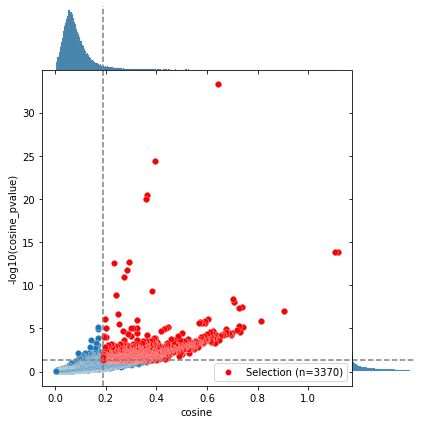

In [3]:
selection = C.select_significant_rules()

<a id="automated"></a>

## Method 1: Automated analysis

There are two different ways to run this analysis. The automated way will be shown in this chapter. Followed by an in depth guide showing the analysis step by step.  \
Here we will start with the __automated__ analysis for __all__ selected rules.  

In [4]:
selection.analyze_distances()

INFO: DistObject successfully created! It can be accessed via combobj.distObj
INFO: Calculating distances
INFO: Directionality is not taken into account
INFO: Normalizing data.
INFO: Done finding distances! Results are found in .distances
INFO: Run .linregress_all() to fit linear regression
INFO: Fitting linear regression.
INFO: Linear regression finished! Results can be found in .linres
INFO: Correcting background
INFO: Background correction finished! Results can be found in .corrected
INFO: Smoothing signals with window size 3
INFO: Shifting signals above zero
INFO: Analyzing Signal
INFO: Done analyzing signal. Results are found in .peaks


In [5]:
selection.distObj.peaks.loc[(selection.distObj.peaks.TF1 == "ZNF121") & (selection.distObj.peaks.TF2 == "ZNF770")]

,TF1,TF2,Distance,Peak Heights,Prominences,Prominence Threshold
0,ZNF121,ZNF770,26,0.0990,0.0990,0.0202
1,ZNF121,ZNF770,58,0.0558,0.0545,0.0202
2,ZNF121,ZNF770,66,0.0493,0.0426,0.0202
3,ZNF121,ZNF770,99,0.0204,0.0204,0.0202


INFO: Signal is already shifted! smoothing it again may cause false result. Skipping smoothing.
INFO: Signals already above zero, skipping shift.
INFO: Analyzing Signal
INFO: Done analyzing signal. Results are found in .peaks


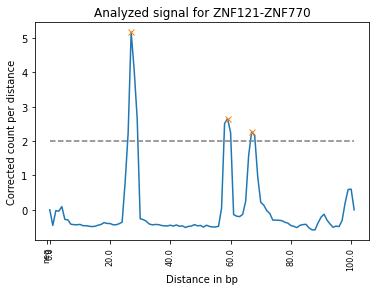

In [6]:
selection.distObj.analyze_signal_all(smooth_window=3, prominence="zscore", stringency=2)
selection.distObj.peaks
selection.distObj.plot_analyzed_signal(("ZNF121", "ZNF770"), zscore=True)

<a id="sbs"></a>

## Method 2: Step-by-Step Analysis

Besides the automated way, the analysis can be done __step-by-step__. This chapter is an detailed guide, covering all 5 major steps.

<a id="1"></a>

### 1. Create a distance object

The binding distance analysis can be started from within any _combObj_. In this example the appropiate object is called __selection__, since we only want to use __significant__ rules, not all.

In [7]:
selection.create_distObj()

INFO: DistObject successfully created! It can be accessed via combobj.distObj


As stated in the information message, the distObj should be created successfully and filled with all important information to start the distance analysis. This includes parameters set for the market masket analysis. 

In [8]:
selection.distObj

The 3370 rules (market basket results) selected earlier by _select.significant_rules()_ are automatically passed to the distance object during creation:

In [9]:
selection.distObj.rules

,TF1,TF2,TF1_TF2_count,TF1_count,TF2_count,n_baskets,TF1_TF2_support,TF1_support,TF2_support,cosine,cosine_pvalue,cosine_pvalue_adj
ZNF121-ZNF770,ZNF121,ZNF770,1715,1113,2113,180898,0.009480,0.006153,0.011681,1.118322,1.397802e-14,2.232052e-09
ZNF770-ZNF121,ZNF770,ZNF121,1715,2113,1113,180898,0.009480,0.011681,0.006153,1.118322,1.397802e-14,2.232052e-09
PAX5-ZNF770,PAX5,ZNF770,1651,1055,2113,180898,0.009127,0.005832,0.011681,1.105786,1.613797e-14,2.576959e-09
ZNF770-PAX5,ZNF770,PAX5,1651,2113,1055,180898,0.009127,0.011681,0.005832,1.105786,1.613797e-14,2.576959e-09
SP1-SP2,SP1,SP2,894,914,1069,180898,0.004942,0.005053,0.005909,0.904431,9.090433e-08,1.451588e-02
...,...,...,...,...,...,...,...,...,...,...,...,...
ZIM3-FEZF1,ZIM3,FEZF1,128,688,676,180898,0.000708,0.003803,0.003737,0.187691,3.930882e-02,1.000000e+00
LEF1-FEZF1,LEF1,FEZF1,135,768,676,180898,0.000746,0.004245,0.003737,0.187361,4.925186e-02,1.000000e+00
FEZF1-LEF1,FEZF1,LEF1,135,676,768,180898,0.000746,0.003737,0.004245,0.187361,4.925186e-02,1.000000e+00
MITF-NFKB2,MITF,NFKB2,53,196,410,180898,0.000293,0.001083,0.002266,0.186963,1.847069e-02,1.000000e+00


To unify the analysis steps between the market basket and the binding distance ones, the parameters for the 
>1. _minimal distance_
2. _maximal distance_
3. _maximal allowed overlap_ 
4. _directionality_ 

will be set automatically when creating the distance object according to the values used for the _market basket analysis_ step. 

In [10]:
selection.distObj.max_overlap

0.0

To adjust those parameters, simply set them:

In [11]:
selection.distObj.max_dist = 300
selection.distObj.max_dist

300

In [12]:
selection.distObj.max_dist = 100
selection.distObj.max_dist

100

<a id="anchor"></a>

#### Anchor mode

TFCOMB distance analysis supports three different anchor modes: _inner_ , _outer_ and _center_. The recommended mode is __inner__. 

#TODO: Insert good anchor explanation

<a id="2"></a>

### 2. Distance counting

After creating the distObj the first step is to count the distances. This will be done with .count_distances().
In this step it is important to decide 
 1. whether the data should be normalized to increase comparability (recommended) or not and 

 2. if the directionality should be taken into account. 

__Normalization__ is done the following way:

\begin{equation}
\frac{count_i}{\sum_{n=minDist}^{maxDist}count_n} for\:each\:i∈\{minDist..maxDist\}
\end{equation}

If __directionality__ is taken into account the position of the transcription factors do matter. This means there is a difference between _TFA -> TFB_ and _TFB -> TFA_ (compare [Directionality analysis](./Directionality_analysis.ipynb) notebook). Otherwise _TFA -> TFB_ and _TFB -> TFA_ are the same.
 
Per default data will be __normailzed__ (True) and __directionality__ decision __is copied__ (None) from the market basket step.

In [30]:
selection.distObj.count_distances(normalize=True, directional=None)

INFO: Calculating distances
INFO: Directionality is not taken into account
INFO: Normalizing data.
INFO: Done finding distances! Results are found in .distances
INFO: Run .linregress_all() to fit linear regression


In [14]:
selection.distObj.distances

,TF1,TF2,neg,0,1,2,3,4,5,6,...,91,92,93,94,95,96,97,98,99,100
ZNF121-ZNF770,ZNF121,ZNF770,0.0,0.001166,0.000000,0.022157,0.000583,0.006997,0.002915,0.000000,...,0.006414,0.002332,0.003499,0.001749,0.004082,0.002915,0.011079,0.030321,0.023324,0.011662
ZNF770-ZNF121,ZNF770,ZNF121,0.0,0.001166,0.000000,0.022157,0.000583,0.006997,0.002915,0.000000,...,0.006414,0.002332,0.003499,0.001749,0.004082,0.002915,0.011079,0.030321,0.023324,0.011662
PAX5-ZNF770,PAX5,ZNF770,0.0,0.051484,0.001817,0.041793,0.002423,0.000000,0.000606,0.002423,...,0.021805,0.012114,0.003634,0.004240,0.002423,0.004240,0.004240,0.010297,0.025439,0.015142
ZNF770-PAX5,ZNF770,PAX5,0.0,0.051484,0.001817,0.041793,0.002423,0.000000,0.000606,0.002423,...,0.021805,0.012114,0.003634,0.004240,0.002423,0.004240,0.004240,0.010297,0.025439,0.015142
SP1-SP2,SP1,SP2,0.0,0.004474,0.005593,0.005593,0.004474,0.012304,0.013423,0.012304,...,0.005593,0.012304,0.004474,0.004474,0.003356,0.010067,0.006711,0.005593,0.011186,0.011186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZIM3-FEZF1,ZIM3,FEZF1,0.0,0.023438,0.000000,0.007812,0.015625,0.039062,0.007812,0.031250,...,0.007812,0.000000,0.000000,0.000000,0.015625,0.000000,0.023438,0.054688,0.007812,0.023438
LEF1-FEZF1,LEF1,FEZF1,0.0,0.037037,0.051852,0.022222,0.007407,0.007407,0.022222,0.007407,...,0.000000,0.000000,0.007407,0.007407,0.000000,0.007407,0.000000,0.007407,0.007407,0.007407
FEZF1-LEF1,FEZF1,LEF1,0.0,0.037037,0.051852,0.022222,0.007407,0.007407,0.022222,0.007407,...,0.000000,0.000000,0.007407,0.007407,0.000000,0.007407,0.000000,0.007407,0.007407,0.007407
MITF-NFKB2,MITF,NFKB2,0.0,0.000000,0.000000,0.000000,0.018868,0.000000,0.018868,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


The resulting dataframe is constructed as followed: 
- __columns__: First the transcription factor for the pair (TF1, TF2) followed by the distances in bp (except the _neg_ column, which is explained below)
- __rows__: each row representing one rule (pair) with the corresponding results

<a id="neg"></a>

#### negative distances
The _neg_ column only shows up if no minimum distance (min_dist equals 0) is set, because it unites all negative distances. \
Negative distance can occur if the distance anchor is set to _inner_ mode (see [Anchor mode](#Anchor-mode)) and overlapping is allowed. If overlapping is not allowed (and therefore set to 0) the uncorrected values within the _neg_ column should always be 0. 


#### directionality
Since we didn't count directional the values for the pairs tf1-tf2 and tf2-tf1 should be equal.For example in the DataFrame above the results for _ZNF121_-_ZNF770_ are the same as for _ZNF770_-_ZNF121_. This is not true if directionality is considered



There are different ways to plot the distance distribution, you can use the _.plot_dens()_ function which creates a kernel density estimate (KDE) plot and the _plot_hist()_ function which creates a histogram of the distribution.

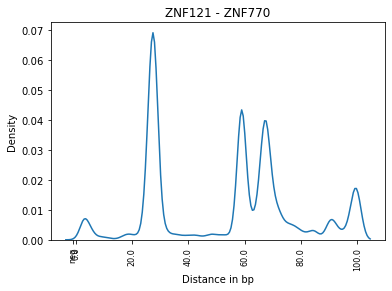

In [15]:
selection.distObj.plot_dens(("ZNF121", "ZNF770"))

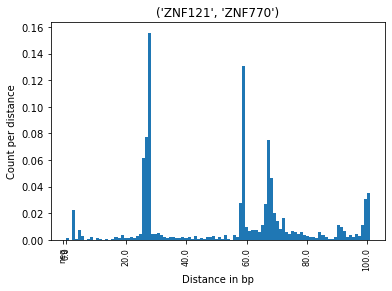

In [16]:
selection.distObj.plot_hist(("ZNF121", "ZNF770"))

For __both__ plots the __x-axis__ shows the distance in bp. \
<a id="dist"></a>
For example a distance of 100 means the anchors (depending on anchor mode, please refere to [Anchor mode](#Anchor-mode) on this topic) are 100 bp away of each other. [Here](#negative-distances) is an explanation for the _neg_ distance.\
For the __y-axis__ of the __kde plot__ the density estimation is shown. \
For the __y-axis__ of the __histogram__ the counts per distance is shown. Since we normalized the data, those numbers are not the raw count, but the fraction of counts for this distance in regards to the total amount of counts for all distances for the shown pair. 

<a id="3"></a>

### 3. Linear regression

To separate the signal from the background noise a linear regression for every signal needs to be fitted next. The result of the fitted line for every pair can be found in the .linres attribute of the distance object.

In [17]:
selection.distObj.linregress_all()

INFO: Fitting linear regression.
INFO: Linear regression finished! Results can be found in .linres


In [18]:
selection.distObj.linres

,TF1,TF2,Linear Regression
ZNF121-ZNF770,ZNF121,ZNF770,"(3.2809157774149035e-05, 0.008147059101032925,..."
ZNF770-ZNF121,ZNF770,ZNF121,"(3.2809157774149035e-05, 0.008147059101032925,..."
PAX5-ZNF770,PAX5,ZNF770,"(-2.4316650657691113e-07, 0.009816201477209584..."
ZNF770-PAX5,ZNF770,PAX5,"(-2.4316650657691113e-07, 0.009816201477209584..."
SP1-SP2,SP1,SP2,"(-3.483765330986738e-05, 0.011563223060775753,..."
...,...,...,...
ZIM3-FEZF1,ZIM3,FEZF1,"(-3.7372562213388685e-05, 0.011691235960403579..."
LEF1-FEZF1,LEF1,FEZF1,"(-7.275427714102075e-05, 0.013478012564249, -0..."
FEZF1-LEF1,FEZF1,LEF1,"(-7.275427714102075e-05, 0.013478012564249, -0..."
MITF-NFKB2,MITF,NFKB2,"(-0.0001618460823486096, 0.01797714872723223, ..."


The resulting dataframe is constructed as followed: 
- __columns__: First the transcription factor for the pair (TF1, TF2) followed by the linear regression object
- __rows__: each row representing one rule (pair) with the corresponding results

The fitted linear regression line can be plotted with the .plot_linres() command. 

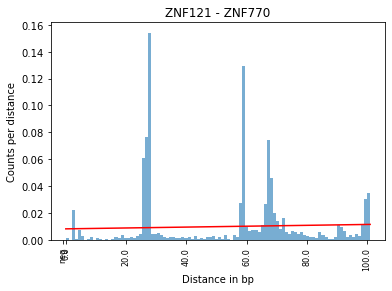

In [19]:
selection.distObj.plot_linres(("ZNF121", "ZNF770"))

On the __x-axis__ on this plot the distance in bp is shown.\
For example a distance of 100 means the anchors (depending on anchor mode, please refere to [Anchor mode](#Anchor-mode) on this topic) are 100 bp away of each other. [Here](#negative-distances) is an explanation for the _neg_ distance.\
On the __y-axis__ of the histogram the counts per distance is shown. Since we normalized the data, those numbers are not the raw count, but the fraction of counts for this distance in regards to the total amount of counts for alle distances for the shown pair (see [Distance counting](#2.-Distance-counting) for details on how normalization is done). 

The __red line__ indicates the linear regression line which was fitted during this step. 

<a id="4"></a>

### 4. Background correction

Based on the linear regression, the background needs to be corrected. Therefore the linear regression is subtracted from the signal. 

In [20]:
selection.distObj.correct_all()

INFO: Correcting background
INFO: Background correction finished! Results can be found in .corrected


In [21]:
selection.distObj.corrected

,TF1,TF2,neg,0,1,2,3,4,5,6,...,91,92,93,94,95,96,97,98,99,100
ZNF121-ZNF770,ZNF121,ZNF770,-0.008147,-0.007014,-0.008213,0.013912,-0.007695,-0.001314,-0.005428,-0.008377,...,-0.004752,-0.008866,-0.007733,-0.009515,-0.007215,-0.008414,-0.000284,0.018926,0.011896,0.000201
ZNF770-ZNF121,ZNF770,ZNF121,-0.008147,-0.007014,-0.008213,0.013912,-0.007695,-0.001314,-0.005428,-0.008377,...,-0.004752,-0.008866,-0.007733,-0.009515,-0.007215,-0.008414,-0.000284,0.018926,0.011896,0.000201
PAX5-ZNF770,PAX5,ZNF770,-0.009816,0.041668,-0.007999,0.031977,-0.007392,-0.009815,-0.009209,-0.007392,...,0.012011,0.002320,-0.006159,-0.005553,-0.007370,-0.005553,-0.005553,0.000505,0.015647,0.005351
ZNF770-PAX5,ZNF770,PAX5,-0.009816,0.041668,-0.007999,0.031977,-0.007392,-0.009815,-0.009209,-0.007392,...,0.012011,0.002320,-0.006159,-0.005553,-0.007370,-0.005553,-0.005553,0.000505,0.015647,0.005351
SP1-SP2,SP1,SP2,-0.011563,-0.007054,-0.005901,-0.005866,-0.006950,0.000915,0.002069,0.000985,...,-0.002765,0.003981,-0.003814,-0.003779,-0.004863,0.001883,-0.001438,-0.002521,0.003106,0.003141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZIM3-FEZF1,ZIM3,FEZF1,-0.011691,0.011784,-0.011616,-0.003767,0.004083,0.027558,-0.003655,0.019820,...,-0.000440,-0.008216,-0.008178,-0.008141,0.007522,-0.008066,0.015409,0.046696,-0.000141,0.015521
LEF1-FEZF1,LEF1,FEZF1,-0.013478,0.023632,0.038519,0.008962,-0.005780,-0.005707,0.009181,-0.005561,...,-0.006785,-0.006712,0.000768,0.000841,-0.006494,0.000987,-0.006348,0.001132,0.001205,0.001278
FEZF1-LEF1,FEZF1,LEF1,-0.013478,0.023632,0.038519,0.008962,-0.005780,-0.005707,0.009181,-0.005561,...,-0.006785,-0.006712,0.000768,0.000841,-0.006494,0.000987,-0.006348,0.001132,0.001205,0.001278
MITF-NFKB2,MITF,NFKB2,-0.017977,-0.017815,-0.017653,-0.017492,0.001538,-0.017168,0.001862,-0.016844,...,-0.003087,-0.002925,-0.002764,-0.002602,-0.002440,-0.002278,-0.002116,-0.001954,-0.001793,-0.001631


The resulting dataframe is constructed as followed: 
- __columns__: First the transcription factor for the pair (TF1, TF2) followed by the __corrected__ distances in bp 
- __rows__: each row representing one rule (pair) with the corresponding results

The corrected distribution can be plotted with the .plot_corrected() command. 

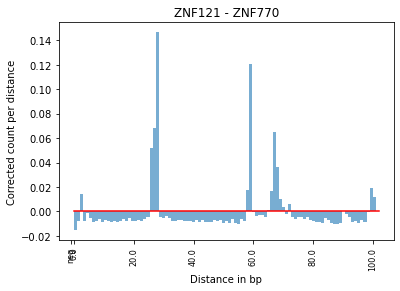

In [22]:
selection.distObj.plot_corrected(("ZNF121", "ZNF770"))

This Plot shows the __corrected__ signal.

On the __x-axis__ the distance in bp is shown. \
For example a distance of 100 means the anchors (depending on anchor mode, please refere to [Anchor mode](#Anchor-mode) on this topic) are 100 bp away of each other. [Here](#negative-distances) is an explanation for the _neg_ distance.\
On the __y-axis__ of the histogram the __corrected__ counts per distance is shown. Since we normalized the data, those numbers are not the raw count, but the fraction of counts for this distance in regards to the total amount of counts for all distances for the shown pair (see [Distance counting](#2.-Distance-counting) for details on how normalization is done).

Since we subtracted the linear regression line from the signal, the red line should always be zero with the signal moving around.

<a id="5"></a>

### 5. Analyse signal 

As a last step, the corrected signal can now be analyzed. Peaks will be called with [_scipy.signal.find_peaks()_](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html). Three different threshold modes are available: 

1. "median"
2. "zscore" 
3. (number)

The two modes __median__ and __zscore__ will be shown in the following sections. If a number is passed instead of a mode, the number will be passed to [_scipy.signal.find_peaks()_](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)

<a id="median"></a>

#### 5.A. Median

If prominence is set to __median__ the prominence threshold is set to the median (of the corrected signal) for each signal. With the parameter _stringency_ a multiplicator can be set. For example if stringency is 2, the threshold prominence will be two times the median. 

In [23]:
selection.distObj.analyze_signal_all(smooth_window=3, prominence="median", stringency=2)

INFO: Smoothing signals with window size 3
INFO: Shifting signals above zero
INFO: Analyzing Signal
INFO: Done analyzing signal. Results are found in .peaks


In [24]:
selection.distObj.peaks

,TF1,TF2,Distance,Peak Heights,Prominences,Prominence Threshold
0,ZNF121,ZNF770,26,0.0990,0.0990,0.0202
1,ZNF121,ZNF770,58,0.0558,0.0545,0.0202
2,ZNF121,ZNF770,66,0.0493,0.0426,0.0202
3,ZNF121,ZNF770,99,0.0204,0.0204,0.0202
4,ZNF770,ZNF121,26,0.0990,0.0990,0.0202
...,...,...,...,...,...,...
5013,LEF1,FEZF1,87,0.0301,0.0301,0.0249
5014,FEZF1,LEF1,1,0.0362,0.0362,0.0249
5015,FEZF1,LEF1,87,0.0301,0.0301,0.0249
5016,MITF,NFKB2,31,0.2189,0.2189,0.0360


The resulting dataframe is constructed as followed: 
- __columns__: First the transcription factor for the pair (TF1, TF2) followed by 
    1. __prefered distance__ in bp
    2. __peak heights__ height of the peak (calculated by [_find_peaks()_](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)).
    3. __prominence__ prominence of the peak (calculated by [_find_peaks()_](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)).
    4. __prominence threshold__ minimum prominence needed to be considered as peak (default the [median](#5.A.-Median) of the signal).
    
    
- __rows__: each row representing one rule (pair) at a distinct prefered binding distance with the corresponding results

The corrected distribution can be plotted with the .plot_analyzed_signal() command. 

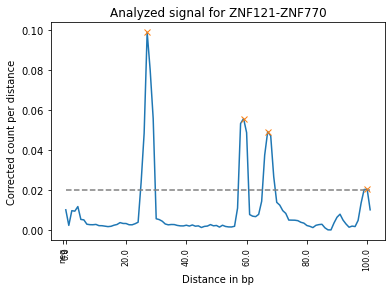

In [25]:
selection.distObj.plot_analyzed_signal(("ZNF121", "ZNF770"))

This plot shows the __corrected__ signal with the __called peaks__, indicated by a cross.

On the __x-axis__ the distance in bp is shown. \
For example a distance of 100 means the anchors (depending on anchor mode, please refere to [Anchor mode](#Anchor-mode) on this topic) are 100 bp away of each other. [Here](#negative-distances) is an explanation for the _neg_ distance.\
On the __y-axis__ of the plot the __corrected__ counts per distance is shown. Since we normalized the data, those numbers are not the raw count, but the fraction of counts for this distance in regards to the total amount of counts for all distances for the shown pair (see [Distance counting](#2.-Distance-counting) for details on how normalization is done).

The __grey dottet line__ shows the decision boundary (in this example 2\*median)

In [26]:
selection.distObj.peaks.loc[(selection.distObj.peaks.TF1 == "ZNF121") & (selection.distObj.peaks.TF2 == "ZNF770")]

,TF1,TF2,Distance,Peak Heights,Prominences,Prominence Threshold
0,ZNF121,ZNF770,26,0.0990,0.0990,0.0202
1,ZNF121,ZNF770,58,0.0558,0.0545,0.0202
2,ZNF121,ZNF770,66,0.0493,0.0426,0.0202
3,ZNF121,ZNF770,99,0.0204,0.0204,0.0202


The results in the .peaks table and the plot matches. For this _ZNF121_-_ZNF770_ 4 peaks were found, which also can be seen in the plot at positions: 
> 1. distance:  26 
2. distance: 58 
3. distance: 66 
4. distance: 99 

Meaning the median threshold with stringency of 2 identifies 4 different preferred distances for this pair. Please note, that the height of the distances differ!

<a id="zscore"></a>

#### 5.B. Zscore

If prominence is set to __zscore__ the prominence threshold is set to the zscore (of the corrected signal) for each signal. Aside from that the signal is translated from counts per distance to signal per distance. The resulting signal preserves its shape, but mind the change of the unit. \
With the parameter _stringency_ the zscore threshold is set. For example if stringency is 2, the threshold prominence (for the score translated signal) will be a zscore of two. 

In [27]:
selection.distObj.analyze_signal_all(smooth_window=3, prominence="zscore", stringency=2)
selection.distObj.peaks

INFO: Signal is already shifted! smoothing it again may cause false result. Skipping smoothing.
INFO: Signals already above zero, skipping shift.
INFO: Analyzing Signal
INFO: Done analyzing signal. Results are found in .peaks


,TF1,TF2,Distance,Peak Heights,Prominences,Prominence Threshold
0,ZNF121,ZNF770,26,5.1403,5.6288,2
1,ZNF121,ZNF770,58,2.6406,3.1542,2
2,ZNF121,ZNF770,66,2.2658,2.4651,2
3,ZNF770,ZNF121,26,5.1403,5.6288,2
4,ZNF770,ZNF121,58,2.6406,3.1542,2
...,...,...,...,...,...,...
14847,FEZF1,LEF1,51,1.8174,3.2005,2
14848,FEZF1,LEF1,69,1.6079,2.7158,2
14849,FEZF1,LEF1,87,3.1827,3.9752,2
14850,MITF,NFKB2,31,5.6329,5.9654,2


The resulting dataframe is constructed as followed: 
- __columns__: First the transcription factor for the pair (TF1, TF2) followed by 
    1. __prefered distance__ in bp 
    2. __peak heights__ height of the peak (calculated by [_find_peaks()_](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)).
    3. __prominence__ prominence of the peak (calculated by [_find_peaks()_](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)).
    4. __prominence threshold__ minimum prominence needed to be considered as peak (in this example the [zscore](#5.B.-Zscore) of the signal).
    
    
- __rows__: each row representing one rule (pair) at a distinct prefered binding distance with the corresponding results

The corrected distribution can be plotted with the .plot_analyzed_signal() command. \
__Note__: Since we used the zscore and therefore a translated signal, we need to tell the plotting function to use the zscore label (parameter zscore = True)

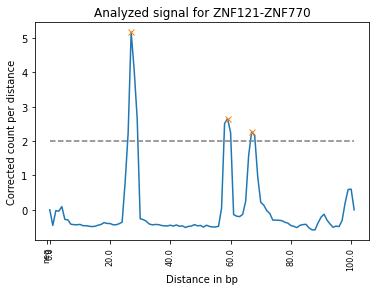

In [28]:
selection.distObj.plot_analyzed_signal(("ZNF121", "ZNF770"), zscore=True)

This plot shows the __corrected__ signal with the __called peaks__, indicated by a cross.

On the __x-axis__ the distance in bp is shown. \
For example a distance of 100 means the anchors (depending on anchor mode, please refere to [Anchor mode](#Anchor-mode) on this topic) are 100 bp away of each other. [Here](#negative-distances) is an explanation for the _neg_ distance.\
On the __y-axis__ of the plot the calculated __zscore__ per distance is shown. 

The __grey dottet line__ shows the decision boundary (in this example a zscore of 2)

In [29]:
selection.distObj.peaks.loc[(selection.distObj.peaks.TF1 == "ZNF121") & (selection.distObj.peaks.TF2 == "ZNF770")]

,TF1,TF2,Distance,Peak Heights,Prominences,Prominence Threshold
0,ZNF121,ZNF770,26,5.1403,5.6288,2
1,ZNF121,ZNF770,58,2.6406,3.1542,2
2,ZNF121,ZNF770,66,2.2658,2.4651,2


The results in the .peaks table and the plot matches. For this _ZNF121_-_ZNF770_ 3 peaks were found, which also can be seen in the plot at positions: 
> 1. distance:  26 
2. distance: 58 
3. distance: 66 

Meaning the zscore threshold with stringency of 2 identifies 3 different preferred distances for this pair. Please note, that the height of the distances differ!